In [ ]:
import pandas as pd
import mysql.connector
import os

# List of CSV files and their corresponding table names
csv_files = [
    ('customers.csv', 'customers'),
    ('orders.csv', 'orders'),
    ('sellers.csv', 'sellers'),
    ('products.csv', 'products'),
    ('geolocation.csv', 'geolocation'),
    ('payments.csv', 'payments'),
    ('order_items.CSV', 'order_items')# Added payments.csv for specific handling
]

# Connect to the MySQL database
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='*******',
    database='ecommerce'
)
cur = conn.cursor()


# Folder containing the CSV files
folder_path = 'C:/Users/ASUS/Music/E commerce project , WS cube'

def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Replace NaN with None to handle SQL NULL
    df = df.where(pd.notnull(df), None)
    
    # Debugging: Check for NaN values
    print(f"Processing {csv_file}")
    print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

    # Clean column names
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

    # Generate the CREATE TABLE statement with appropriate data types
    columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
    create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
    cur.execute(create_table_query)

    # Insert DataFrame data into the MySQL table
    for _, row in df.iterrows():
        # Convert row to tuple and handle NaN/None explicitly
        values = tuple(None if pd.isna(x) else x for x in row)
        sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
        cur.execute(sql, values)

    # Commit the transaction for the current CSV file
    conn.commit()

# Close the connection
conn.close()

Processing customers.csv
NaN values before replacement:
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

Processing orders.csv
NaN values before replacement:
order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

Processing sellers.csv
NaN values before replacement:
seller_id                 0
seller_zip_code_prefix    0
seller_city               0
seller_state              0
dtype: int64

Processing products.csv
NaN values before replacement:
product_id                      0
product category              610
product_name_length           610
product_description_length    610
product_photos_qty            610
prod

In [31]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import mysql.connector 

db = mysql.connector.connect(host = "localhost",
                            username = "root",
                            password = "*********",
                            database = "ecommerce")

cur = db.cursor()


In [34]:
#1. List all unique cities where customers are located.
query = """select distinct(customer_city) from customers"""
cur.execute ( query )
data = cur.fetchall()
df = pd.DataFrame(data)
df

,0
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas
...,...
4114,siriji
4115,natividade da serra
4116,monte bonito
4117,sao rafael


In [35]:
#2 Count the number of orders placed in 2017.
q = """select count(order_id)from orders where order_purchase_timestamp = 2017"""
cur.execute(q)
data = cur.fetchall()
"Total orders placed in 2017 are ", data[0][0]



('Total orders placed in 2017 are ', 90202)

#3 Find the total sales per category.

In [36]:
q = """ select upper(p.product_category), round(sum(py.payment_value),2) as Total_sale
from products as p
join order_items
on p.product_id = order_items.product_id
join payments as py
on order_items.order_id = py.order_id
group by product_category
order by Total_sale desc;
 """
cur.execute(q)
data = cur.fetchall()
df= pd.DataFrame(data, columns = ["Category","Sale"]) 
df

,Category,Sale
0,BED TABLE BATH,13700429.37
1,HEALTH BEAUTY,13258984.96
2,COMPUTER ACCESSORIES,12682643.57
3,FURNITURE DECORATION,11441411.13
4,WATCHES PRESENT,11433733.43
...,...,...
69,PC GAMER,17395.44
70,HOUSE COMFORT 2,13684.32
71,CDS MUSIC DVDS,9595.44
72,FASHION CHILDREN'S CLOTHING,6285.36


#3 Calculate the percentage of orders that were paid in installments

In [37]:
q = """ select sum((case when payment_installments >=1 then 1 else 0 end)) / count(*) *100 from payments"""
cur.execute(q)
data = cur.fetchall()
'Total percentage of orders that were paid in installments is ', data

('Total percentage of orders that were paid in installments is ',
 [(Decimal('99.9981'),)])

#4 Count the number of customers from each state. 

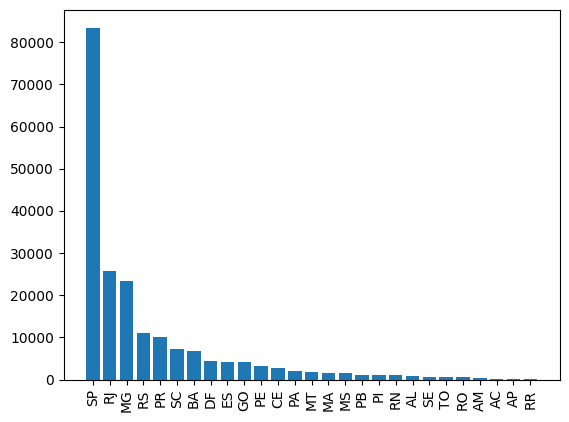

In [38]:
q = """select count(customer_id) as Total_customer, customer_state
from customers
group by customer_state
order by Total_customer desc"""

cur.execute(q)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["Total_customer" , "State"])
plt.bar(df["State"], df["Total_customer"])
plt.xticks(rotation = 90)
plt.show()

Intermediate Queries-
1. Calculate the number of orders per month in 2018.

In [39]:
q = """select 
monthname(order_purchase_timestamp) as month , count(order_id) as T_order
from orders
where order_purchase_timestamp = 2018
group by month
order by month desc """
cur.execute(q)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["month", "T_order"])
df

,month,T_order
0,September,32
1,October,8
2,May,13746
3,March,14422
4,June,12334
5,July,12584
6,January,14538
7,February,13456
8,August,13024
9,April,13878


#2Find the average number of products per order, grouped by customer city.

In [ ]:
cur = cursor   

In [40]:
q = """with count_per_order as (
select orders.order_id, orders.customer_id ,count(order_items.order_id) as oc
from orders join order_items 
on orders.order_id = order_items.order_id
group by orders.order_id, orders.customer_id
)
select customers.customer_city, round(avg(oc),2) as Avg_order
from customers join count_per_order
on customers.customer_id = count_per_order.customer_id
group by customers.customer_city
order by  Avg_order desc
limit 10; """
cur.execute(q)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["City", "Avg_order"])
df 

,City,Avg_order
0,padre carvalho,28.00
1,celso ramos,26.00
2,datas,24.00
3,candido godoi,24.00
4,matias olimpio,20.00
5,cidelandia,16.00
6,teixeira soares,16.00
7,picarra,16.00
8,morro de sao paulo,16.00
9,curralinho,16.00


3. Calculate the percentage of total revenue contributed by each product category.

In [41]:
q = """ select upper(p.product_category),
 round((sum(py.payment_value)/(select sum(payment_value) from payments))*100,2) as Total_sale
from products as p
join order_items
on p.product_id = order_items.product_id
join payments as py
on order_items.order_id = py.order_id
group by product_category
order by Total_sale desc
limit 10; """
cur.execute(q)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["Revenue", "Cateogory(in %)"])
df 

,Revenue,Cateogory(in %)
0,BED TABLE BATH,42.79
1,HEALTH BEAUTY,41.41
2,COMPUTER ACCESSORIES,39.61
3,FURNITURE DECORATION,35.73
4,WATCHES PRESENT,35.71
5,SPORT LEISURE,34.78
6,HOUSEWARES,27.35
7,AUTOMOTIVE,21.30
8,GARDEN TOOLS,20.95
9,COOL STUFF,19.48


4. Identify the correlation between product price and the number of times a product has been purchased.

In [43]:
import numpy as np

In [45]:
q = """ select products.product_category,
count(order_items.product_id),
round(avg(order_items.price),2)
from products join order_items
on products.product_id = order_items.product_id
group by products.product_category; """
cur.execute(q)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["product", "Purchased", "Avg_price"])
a = df["Purchased"]
b = df["Avg_price"]
np.corrcoef([a,b])


array([[ 1.        , -0.10631514],
       [-0.10631514,  1.        ]])

5. Calculate the total revenue generated by each seller, and rank them by revenue.

In [46]:
q = """  with revenue as (select sum(p.payment_value)as total_revenue, s.seller_id from payments as p
join order_items on p.order_id = order_items.order_id join sellers as s
on order_items.seller_id = s.seller_id
group by s.seller_id)

select seller_id,total_revenue,
rank()over(order by total_revenue DESC ) as rank_by_revenue
from revenue
limit 10;

  """
cur.execute(q)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["Seller_Id", "Total_Revenue","Ranks"])
df 

,Seller_Id,Total_Revenue,Ranks
0,7c67e1448b00f6e969d365cea6b010ab,4.057335e+06,1
1,1025f0e2d44d7041d6cf58b6550e0bfa,2.465776e+06,2
2,4a3ca9315b744ce9f8e9374361493884,2.409962e+06,3
3,1f50f920176fa81dab994f9023523100,2.322027e+06,4
4,53243585a1d6dc2643021fd1853d8905,2.279225e+06,5
5,da8622b14eb17ae2831f4ac5b9dab84a,2.177755e+06,6
6,4869f7a5dfa277a7dca6462dcf3b52b2,2.113329e+06,7
7,955fee9216a65b617aa5c0531780ce60,1.890578e+06,8
8,fa1c13f2614d7b5c4749cbc52fecda94,1.652106e+06,9
9,7e93a43ef30c4f03f38b393420bc753a,1.481074e+06,10


In [ ]:
cur = cursor

# Advance query
1. Calculate the moving average of order values for each customer over their order history.

In [47]:
q = """  SELECT customer_id, 
       order_purchase_timestamp,
       AVG(payment) OVER (
           PARTITION BY customer_id 
           ORDER BY order_purchase_timestamp 
           ROWS BETWEEN 2 PRECEDING AND CURRENT ROW
       ) AS mov_avg
FROM (
    SELECT o.customer_id, 
           o.order_purchase_timestamp, 
           p.payment_value AS payment 
    FROM payments p 
    JOIN orders o ON p.order_id = o.order_id
) sub;

  """
cur.execute(q)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["Seller_Id", "Total_Revenue","Ranks"])
df 

,Seller_Id,Total_Revenue,Ranks
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.739998
1,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.739998
2,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.739998
3,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.739998
4,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.410004
...,...,...,...
415539,ffffa3172527f765de70084a7e53aae8,2017-09-02 11:53:32,45.500000
415540,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.370001
415541,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.370001
415542,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.370001


2. Calculate the cumulative sales per month for each year.

In [48]:
q = """  select years , months, payment, sum(payment)
over (order by years, months ) cummulative_sales from 
(select year(orders.order_purchase_timestamp) as years,
month(orders.order_purchase_timestamp) as months,
round(sum(payments.payment_value),2) as payment from orders join payments on 
orders.order_id = payments.order_id
group by years , months 
order by years , months 
) as a;
  """
cur.execute(q)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["Years" , "Months","Payment","Cummulative Payment  "])
df 

,Years,Months,Payment,Cummulative Payment
0,2016,9,1008.96,1008.96
1,2016,10,236361.92,237370.88
2,2016,12,78.48,237449.36
3,2017,1,553952.16,791401.52
4,2017,2,1167632.04,1959033.56
5,2017,3,1799454.40,3758487.96
6,2017,4,1671152.12,5429640.08
7,2017,5,2371675.28,7801315.36
8,2017,6,2045105.52,9846420.88
9,2017,7,2369531.68,12215952.56


3. Calculate the year-over-year growth rate of total sales.

In [49]:
q = """  with a as (select year(orders.order_purchase_timestamp) as years, round(sum(payments.payment_value),2) as Payment 
from orders join payments on
orders.order_id = payments.order_id
group by years
order by years)

SELECT years,Payment, LAG(Payment) OVER (ORDER BY years) AS previous_year_sales,
    ROUND(((Payment - LAG(Payment) OVER (ORDER BY years)) / 
            LAG(Payment) OVER (ORDER BY years)) * 100, 2) AS growth_percentage
            FROM a
ORDER BY years;
 ;
  """
cur.execute(q)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["Years" ,"payment","Previous Year sale","growth rate"])
df 

,Years,payment,Previous Year sale,growth rate
0,2016,237449.36,NaN,NaN
1,2017,28998986.91,237449.36,12112.7
2,2018,34799052.21,28998986.91,20.0


4. Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.

In [50]:
q = """   With a as (select customers.customer_id , date(min(orders.order_purchase_timestamp)) as First_order
from customers join orders on 
customers.customer_id = orders.customer_id
group by customer_id)

select a.customer_id, count(distinct orders.order_purchase_timestamp) from a
join orders on a.customer_id = orders.customer_id 
and orders.order_purchase_timestamp > first_order and
orders.order_purchase_timestamp < date_add(first_order, interval 6 month)
group by a.customer_id;
  """
cur.execute(q)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["Customer_id","Repeated customer "]) #unfortunately no repeated customer for 6 Months 
df 

,Customer_id,Repeated customer


#5 Identify the top 3 customers who spent the most money in each year.

In [51]:
q = """    SELECT years, customer_id, payment, d_rank 
FROM (
    SELECT 
        YEAR(o.order_purchase_timestamp) AS years,
        o.customer_id, 
        SUM(p.payment_value) AS payment,
        DENSE_RANK() OVER (
            PARTITION BY YEAR(o.order_purchase_timestamp) 
            ORDER BY SUM(p.payment_value) DESC
        ) AS d_rank
    FROM orders o
    JOIN payments p ON p.order_id = o.order_id
    GROUP BY YEAR(o.order_purchase_timestamp), o.customer_id
) AS a
WHERE d_rank <= 3;
  """
cur.execute(q)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["Year","Customer id ", "Payments", "Rank"])  
df 

,Year,Customer id,Payments,Rank
0,2016,a9dc96b027d1252bbac0a9b72d837fc6,5694.200195,1
1,2016,1d34ed25963d5aae4cf3d7f3a4cda173,5602.959961,2
2,2016,4a06381959b6670756de02e07b83815f,4911.120117,3
3,2017,1617b1357756262bfa56ab541c47bc16,54656.320312,1
4,2017,c6e2731c5b391845f6800c97401a43a9,27717.240234,2
5,2017,3fd6777bbce08a352fddd04e4a7cc8f6,26906.640625,3
6,2018,ec5b2ba62e574342386871631fafd3fc,29099.519531,1
7,2018,f48d464a0baaea338cb25f816991ab1f,27688.839844,2
8,2018,e0a2412720e9ea4f26c1ac985f6a7358,19237.759766,3
